11.16 Data Checking

1120 정상 비정상 데이터 같이 있는 데이터로 훈련 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
import keras
# from keras import optimizers, Sequential
# from keras.models import Model
# from keras.utils.vis_utils import plot_model
# from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
# from keras.callbacks import ModelCheckpoint, TensorBoard

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
tf.random.set_seed(11)

from sklearn.model_selection import train_test_split

SEED = 123
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [2]:
import os
import csv

# lab pc file dir
# path_1 : 정상 데이터
# path_2 : 고장 데이터
path_1 = "C:/Users/sue33/Desktop/pjuns/DB/EM/Training/vibration/vibration/2.2kW/L-DSF-01/정상/"
path_2 = "C:/Users/sue33/Desktop/pjuns/DB/EM/Training/vibration/vibration/2.2kW/L-DSF-01/축정렬불량/"

file_list_1 = os.listdir(path_1)[:]
file_list_2 = os.listdir(path_2)[:]

In [3]:
file_list = file_list_2
# file_list = file_list_1 + file_list_2

In [6]:
# print(len(file_list_1))
# print(len(file_list_2))
# print(len(file_list_1) + len(file_list_2))
# print(len(file_list))

In [5]:
raw_data = []

for i, file_name in enumerate(file_list):
    # if i < 15290:
    #     f = open(path_1+file_name, 'r', encoding='utf-8')
    # else:
    #     f = open(path_2+file_name, 'r', encoding='utf-8')

    f = open(path_2+file_name, 'r', encoding='utf-8')


    # rdr : file to list
    rdr = list(csv.reader(f))

    label = int(rdr[3][1]) # y
    # period = rdr[5][1]
    # rate = rdr[6][1]
    # RMS_value = rdr[7][1]
    # length = rdr[8][1]

    value = np.array(list(rdr[9:]))[:, 1:2] # X
    # value = np.array(value)[:, 1:2]

    f.close()

    # data = [value, label, period, rate, RMS_value, length]
    data = [value, label]
    raw_data.append(data)
    
    # df.append(pd.DataFrame(data, columns=column_name))
    
    # if i == 10:
    #     break


In [8]:
# print(np.array(raw_data)[:, 1:])

In [6]:
column_name = ['y', 'x']
temporalize_df = []

for d in raw_data:
    if d[1] == 0:
        temp = np.concatenate((np.zeros((12000, 1)), d[0]), axis=1)
    else:
        temp = np.concatenate((np.ones((12000, 1)), d[0]), axis=1)
        
    temporalize_df.append(pd.DataFrame(temp, columns=column_name).astype(np.float32))

In [10]:
# print(temporalize_df)

In [7]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(0, len(X)-lookback-1, lookback//2):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [8]:
# n_features = input_X.shape[1]
n_features = 1
lookback = 8

X = []
y = []

for d in temporalize_df:
    input_X = d.loc[:, d.columns != 'y'].values
    input_y = d['y'].values

    nX, ny = temporalize(X = input_X, y = input_y, lookback = lookback)
    X.extend(nX)
    y.extend(ny)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [10]:
# X_train_y0 = X_train[y_train==0.]
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [11]:
print(len(X_train_y0))
print(len(X_train_y1))
print(len(X_valid_y0))
print(len(X_valid_y1))

0
19187
0
4797


In [12]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [13]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [16]:
scaler = StandardScaler().fit(flatten(X_train_y0))

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

In [15]:
X_train_y0_scaled = scale(X_train_y0, scaler).astype(np.float32)
X_train_y1_scaled = scale(X_train_y1, scaler).astype(np.float32)
X_train_scaled = scale(X_train, scaler).astype(np.float32)

NameError: name 'scaler' is not defined

In [24]:
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [-0.]
colwise variance [1.]


In [25]:
X_valid_scaled = scale(X_valid, scaler).astype(np.float32)
X_valid_y0_scaled = scale(X_valid_y0, scaler).astype(np.float32)
X_test_scaled = scale(X_test, scaler).astype(np.float32)

In [47]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 60
batch = 4096
lr = 0.0001

In [32]:
# from keras import backend

# tf.tensorflow_backend._get_available_gpus()

In [48]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 8, 32)             4352      
                                                                 
 lstm_17 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_4 (RepeatVect  (None, 8, 16)            0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 8, 16)             2112      
                                                                 
 lstm_19 (LSTM)              (None, 8, 32)             6272      
                                                                 
 time_distributed_4 (TimeDis  (None, 8, 1)             33        
 tributed)                                            

In [49]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

# es = EarlyStopping(patience=20)
# mc = ModelCheckpoint("your_path/file_name.h5", save_best_only=True)
# rlr = ReduceLROnPlateau(factor=0.3, patience=5)
# csvlogger = CSVLogger("your_path/file_name.log")

In [40]:
tf.debugging.set_log_device_placement(True)

In [41]:
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

In [50]:
lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                # callbacks=[es, mc, rlr, csvlogger],
                                                verbose=2).history

Epoch 1/60
7163/7163 - 462s - loss: 0.2504 - val_loss: 0.1041 - 462s/epoch - 64ms/step
Epoch 2/60
7163/7163 - 460s - loss: 0.0660 - val_loss: 0.0510 - 460s/epoch - 64ms/step
Epoch 3/60
7163/7163 - 467s - loss: 0.0377 - val_loss: 0.0246 - 467s/epoch - 65ms/step
Epoch 4/60
7163/7163 - 459s - loss: 0.0237 - val_loss: 0.0210 - 459s/epoch - 64ms/step
Epoch 5/60
7163/7163 - 445s - loss: 0.0205 - val_loss: 0.0176 - 445s/epoch - 62ms/step
Epoch 6/60
7163/7163 - 432s - loss: 0.0156 - val_loss: 0.0130 - 432s/epoch - 60ms/step
Epoch 7/60
7163/7163 - 423s - loss: 0.0090 - val_loss: 0.0063 - 423s/epoch - 59ms/step
Epoch 8/60
7163/7163 - 426s - loss: 0.0067 - val_loss: 0.0080 - 426s/epoch - 59ms/step
Epoch 9/60
7163/7163 - 428s - loss: 0.0057 - val_loss: 0.0071 - 428s/epoch - 60ms/step
Epoch 10/60
7163/7163 - 430s - loss: 0.0050 - val_loss: 0.0092 - 430s/epoch - 60ms/step
Epoch 11/60
7163/7163 - 424s - loss: 0.0045 - val_loss: 0.0035 - 424s/epoch - 59ms/step
Epoch 12/60
7163/7163 - 423s - loss: 0.00

In [ ]:
# adam = optimizers.Adam(lr)
# lstm_autoencoder.compile(loss='mse', optimizer=adam)

# cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
#                                save_best_only=True,
#                                verbose=0)

# tb = TensorBoard(log_dir='./logs',
#                 histogram_freq=0,
#                 write_graph=True,
#                 write_images=True)

# lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
#                                                 epochs=epochs,
#                                                 batch_size=batch,
#                                                 validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
#                                                 verbose=2).history

In [ ]:
# lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
#                                                 epochs=epochs, 
#                                                 batch_size=batch, 
#                                                 validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                # callbacks=[es, mc, rlr, csvlogger],
#                                                 verbose=2).history

In [52]:
import pickle
# from sklearn.externals import joblib
import joblib

In [51]:
# saved_model = pickle.dumps(lstm_autoencoder)
# joblib.dump(lstm_autoencoder, "1123_model.pkl")

NameError: name 'pickle' is not defined

In [53]:
lstm_autoencoder.save("1123_model.h5")

In [ ]:
# torch.save(lstm_autoencoder, f'./lstm_autoencoder.pt')

In [ ]:
tf.debugging.set_log_device_placement(True)


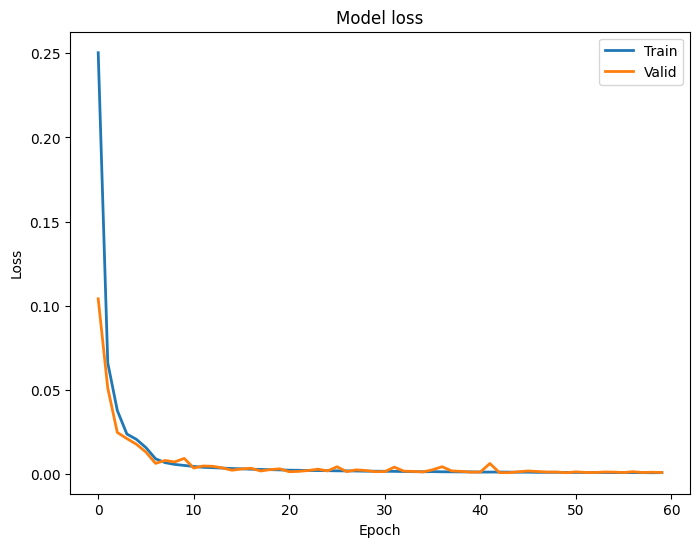

In [54]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

916789/916789 [==============================] - 6136s 7ms/step


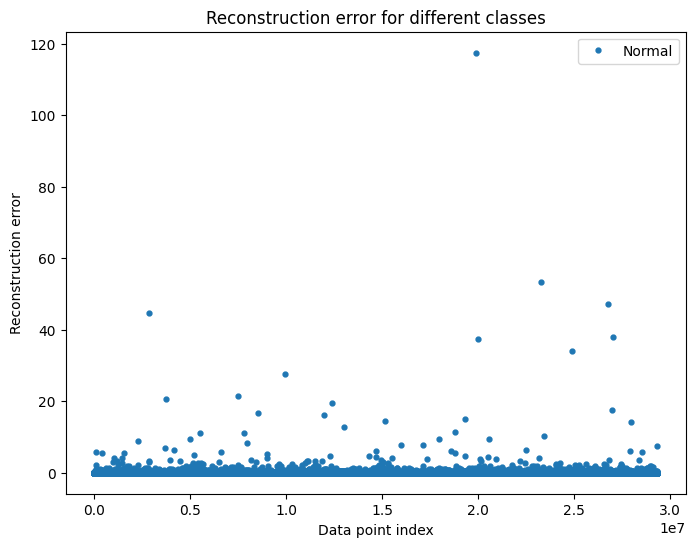

In [55]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

# mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

# error_df = pd.DataFrame({'Reconstruction_error': mse,
#                         'True_class': y_test.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

229198/229198 [==============================] - 1754s 8ms/step


c:\Users\sue33\anaconda3\envs\MLD_py37\lib\site-packages\sklearn\metrics\_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


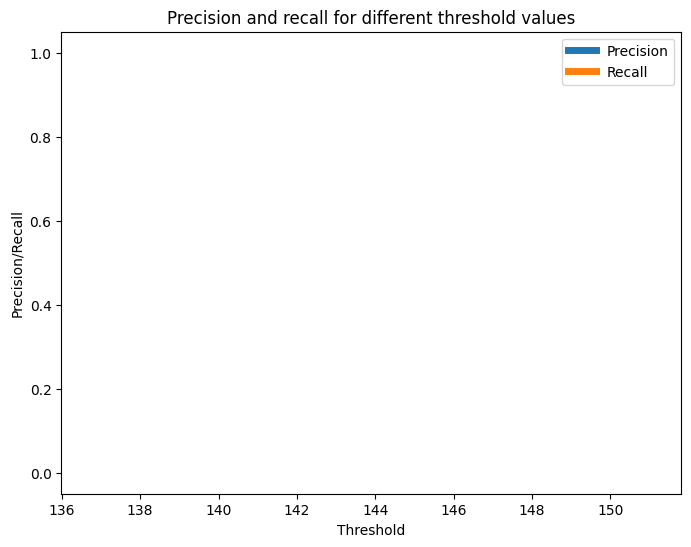

In [56]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

286497/286497 [==============================] - 2214s 8ms/step


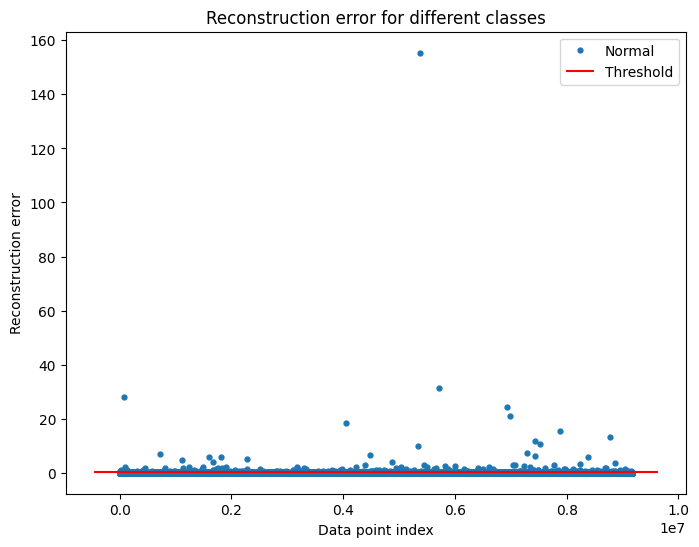

In [57]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [58]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

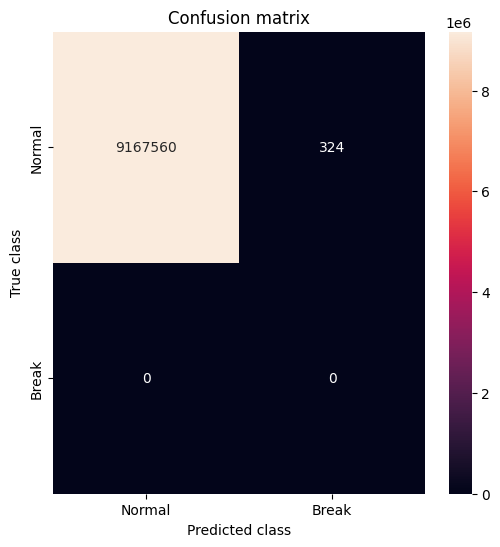

In [59]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

c:\Users\sue33\anaconda3\envs\MLD_py37\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


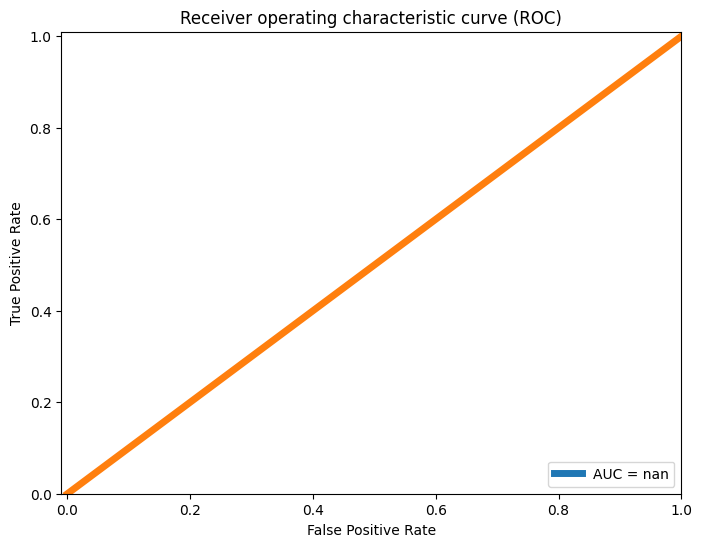

In [60]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()